In [158]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader 
import torchvision
from torchvision import transforms, utils

In [159]:
print("Torch version: {}".format(torch.__version__))
print("Torchvision version: {}".format(torchvision.__version__))

Torch version: 1.0.1
Torchvision version: 0.2.2


In [160]:
torch.cuda.is_available()

False

In [161]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

trainset = torchvision.datasets.CIFAR10(root="./datasets", train=True,
                                        transform=data_transforms['train'], download=True)
trainset_loader = DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./datasets", train=False,
                                      transform=data_transforms['test'], download=True)
testset_loader = DataLoader(testset, batch_size=10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [162]:
def imshow(images):
    images = images / 2 + 0.5
    np_img = images.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

In [163]:
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

print('Images shape {}'.format(images.size()))
print('Labels shape {}'.format(labels.shape))

Images shape torch.Size([10, 3, 32, 32])
Labels shape torch.Size([10])


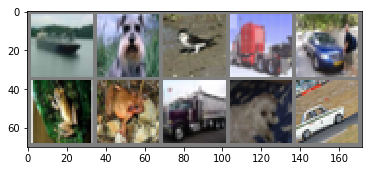

ship dog bird truck car frog frog truck dog car


In [164]:
# Show random 10 images from dataset
imshow(utils.make_grid(images, nrow=5))
print(' '.join('%s' % classes[labels[j]] for j in range(len(labels))))

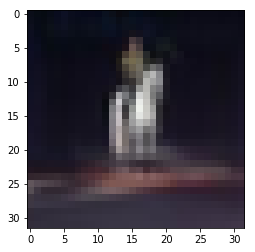

horse


In [165]:
# Show 1 image
images, labels = dataiter.next()
imshow(images[0])
print(classes[labels[0]])

In [166]:
import torch.nn as nn

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            # Input: (32x32x3)
            # Output (32x32x32)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # Output: (32x32x64)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Output: (16x16x64)
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer block2
            
            # Output: (16x16x128)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Output: (16x16x128)
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Output: (8x8x128)
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer block2
            
            # Output: (8x8x256)
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # Output: (8x8x256)
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Output: (4x4x256)
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            # 4096 = 4*4*256
            nn.Linear(in_features=4096, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=10)
        )
        
    def forward(self, x):
        
        x = self.conv_layer(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x = self.fc_layer(x)
        
        return x

In [167]:
# Load exesting model to CPU and set model to evaluation mode
net = CNN()
net.load_state_dict(torch.load("./trained_models/net_15e_080acc.pt", map_location="cpu"))
net.eval()

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace)
    (15): Conv2d(256, 256, kern

In [168]:
import torch.nn.functional as F

def predict(model, x):
    with torch.no_grad():
        output = model(x)
        _, predicted = torch.max(output, 1)
    
    return predicted, F.softmax(output, dim=1).view(-1)

In [169]:
def score(model, dataloader):
    accuracy = 0.0
    corrects = 0
    
    # Iterate over data
    for data in dataloader:
        inputs, labels = data
        
        with torch.no_grad():
            # Get outputs and predicted values
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
        # Sum correct predictions
        corrects += torch.sum(predicted == labels.data)
        
    accuracy = corrects.double() / len(dataloader.dataset)
    
    return accuracy

In [99]:
train_accuracy = score(net, trainset_loader)
test_accuracy = score(net, testset_loader)

print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.8373
Test accuracy: 0.7972


In [170]:
def prepare_image(img):
    # Resize the image to the required size
    resized_img = img.resize((32, 32))
    # And apply data transformations
    transformed_img = data_transforms["test"](resized_img)
    
    return transformed_img.view(1, 3, 32, 32)

In [173]:
from PIL import Image

# Prepare test image
img = Image.open("./test_images/cat_1.jpg")
print("Initial test image shape: {}".format(img.size))

test_img = prepare_image(img)
print("Image shape after preparation: {}".format(test_img.size()))

Initial test image shape: (1000, 667)
Image shape after preparation: torch.Size([1, 3, 32, 32])


In [174]:
# Predict test image's class
predicted, probs = predict(net, test_img)

print("Predicted: {}".format(classes[predicted]))
print("Probabilities: {}".format(probs))
print("Max probability: {:.4f}".format(probs.max(0)[0] * 100))

Predicted: cat
Probabilities: tensor([0.0910, 0.0013, 0.0381, 0.3763, 0.0338, 0.2331, 0.0022, 0.2092, 0.0101,
        0.0050])
Max probability: 37.6254


Text(0.5, 1.0, 'Neural network prediction')

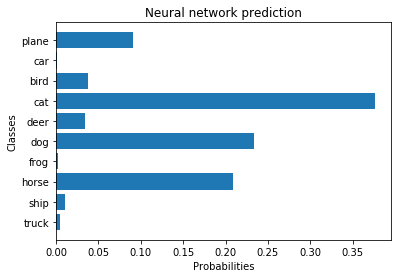

In [175]:
# Plot probabilities
fig, ax = plt.subplots()

y_pos = np.arange(len(probs))
ax.barh(y_pos, probs)
ax.set_yticks(y_pos)
ax.set_yticklabels(classes)
ax.invert_yaxis()
ax.set_xlabel("Probabilities")
ax.set_ylabel("Classes")
ax.set_title("Neural network prediction")